### Outline

1. Universal data reader w/ path as the parameter, maybe add some common dir
2. Get input series, & visualize them
    - One -> two, three, ...?
    - ? possible charateristics?
3. Correlation analysis, including discussion of many info extracting methods
    - Some typical cases?




## Prepare

### Read data
Requirement: some csv with several time series with 'time' field 

tmp/all-data_321.csv n_flow: 4


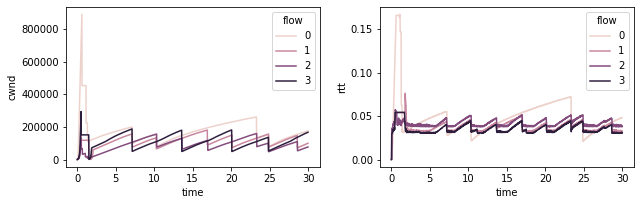

tmp/all-data_322.csv n_flow: 4


<Figure size 432x288 with 0 Axes>

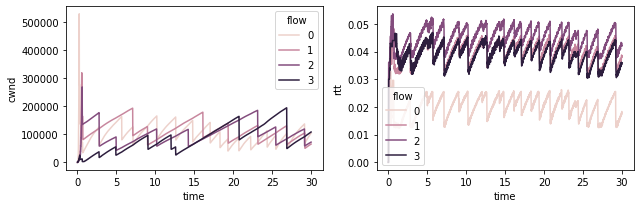

<Figure size 432x288 with 0 Axes>

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import pipeline
import matplotlib.pyplot as plt

# capitalizing 1st letter of manual params
Csv_files = [
    # csv file      num of flow to plot
    ('tmp/all-data_321.csv', 4),    # ? NonCo: cbtnk 100M, normal 100M x2, cross 20M x2, rx Edge 30M
    ('tmp/all-data_322.csv', 4)     # Co: same as above, but w/ rx Edge 100M
]
Fields = ['cwnd', 'rtt']         # candidates: cwnd, rtt, llr, drop, bytes_in_flight, cstate
dfs, ppls = [], []

for i, entry in enumerate(Csv_files):
    csv, n = entry[0], entry[1]
    df = pd.read_csv(csv, index_col=False)
    ppl = pipeline.Pipeline(csv, f'ipybn_{i}')
    dfs.append(df)
    ppls.append(ppl)
    print(csv, 'n_flow:', n)
    ppl.plot_flows(show_flow=n, fields=Fields)      # general plot

plt.show()



### Input Series & Visualization
Obtains the non-cobtnk and cobtnk series with given field, and the first 2 flows as the inputs of later correlation

TODO: 
    1. Cubic case?
    2. Different cycles => different delay/ bw?
    3. Different queue size?

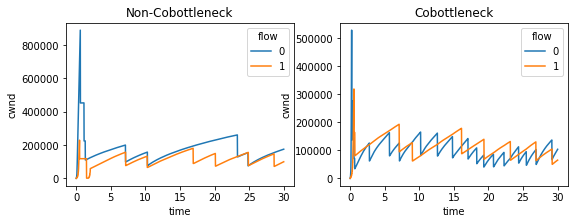

In [3]:
# manually input the run id, flow id, and field
# nonco_df and co_df are what we use exactly as inputs of correlation
field = 'cwnd'                  # candidates: cwnd, rtt, llr, drop, bytes_in_flight, cstate
nonco_df = dfs[0][['time', 'flow', field]]
co_df = dfs[1][['time', 'flow', field]]
cases = ['Non-Cobottleneck', 'Cobottleneck']

# two flows from Non-Cobtnk case
fig, ax = plt.subplots(1,2, figsize=(9,3))
for i, df in enumerate([nonco_df, co_df]):
    df = df[df.flow < 2]        # only the two normal flows
    sns.lineplot(x='time', y=field, hue='flow', data=df, ax=ax[i])
    ax[i].set_title(cases[i])


## Correlation

### Linear Correlation & Mutual Information
TODO: seems the abosolute value of cwnd matters, i.e. co-btnk should have a close cwnd value due to the TCP fairness; this is also neglected by linear correlation

What's the exact meaning and typical usage of these metrics? 
need to explain the difference on our data!

In [45]:
from collections import OrderedDict
from sklearn.metrics import adjusted_mutual_info_score
from sklearn.feature_selection import mutual_info_classif, mutual_info_regression


score_func = OrderedDict([
    ('linear', lambda s1, s2: s1.corr(s2)),
    ('rank', lambda s1, s2: s1.corr(s2, method='spearman')),
    ('cluster_minfo', lambda s1, s2: adjusted_mutual_info_score(s1, s2)),
    ('discrete_minfo', lambda s1, s2: mutual_info_classif(s1, s2)),
    ('continuous_minfo', lambda s1, s2: mutual_info_regression(s1, s2))
])

cols = ['case', 'corr', 'score']
res_df = pd.DataFrame(columns=cols)
for i, df in enumerate([nonco_df, co_df]):
    for tag, func in score_func.items():
        s1 = df[df.flow == 0].reset_index(drop=True).copy()[field]
        s2 = df[df.flow == 1].reset_index(drop=True).copy()[field]
        if abs(len(s1) - len(s2)) < 2:
            if len(s1) < len(s2):
                s2 = s2[:len(s1)]
            else:
                s1 = s1[:len(s2)]
        if tag in ['discrete_minfo', 'continuous_minfo']:
            s1 = s1.to_numpy().reshape(-1, 1)
            score = func(s1, s2)[0]
        else:
            score = func(s1, s2)
        res_df = res_df.append(pd.DataFrame([[i, tag, score]], columns=cols))

print('Score result loaded.')


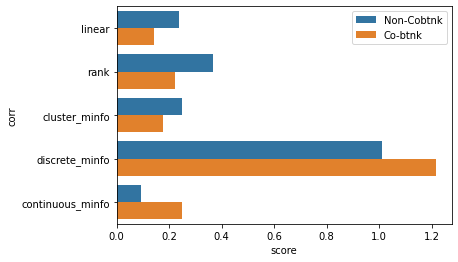

In [46]:

# plot them
ax = sns.barplot(y='corr', x='score', hue='case', data=res_df)
handles, _ = ax.get_legend_handles_labels()
plt.legend(handles, ['Non-Cobtnk', 'Co-btnk'])
